In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [44]:
# Đọc dữ liệu
df = pd.read_csv('penbased-5an-nn.csv', header=None)
df.rename(columns={16: 'target'}, inplace=True)

# Chuẩn hoá dữ liệu: Vì range (0,100), nên chia các features cho 100 để đưa về range (0,1)
df.iloc[:,:-1] = df.iloc[:,:-1]/100
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Chia train-test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Kiểm tra shape train-test
print('Train shape: {} - {}'.format(X_train.shape, y_train.shape))
print('Test shape: {} - {}'.format(X_test.shape, y_test.shape))
display(df.head())

Train shape: (8244, 16) - (8244,)
Test shape: (2748, 16) - (2748,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,target
0,0.00,0.57,0.31,0.68,0.72,0.90,1.00,1.00,0.76,0.75,0.50,0.51,0.28,0.25,0.16,0.00,1
1,0.99,0.80,0.63,1.00,0.25,0.76,0.79,0.68,1.00,0.62,0.97,0.23,0.54,0.00,0.00,0.16,9
2,0.00,0.73,0.19,0.99,0.72,1.00,0.70,0.73,0.32,0.48,0.05,0.18,0.46,0.00,1.00,0.72,2
3,0.12,0.77,0.20,0.62,0.78,0.40,0.50,0.00,0.01,0.17,0.00,0.64,0.23,0.98,1.00,1.00,5
4,0.00,0.98,0.36,0.42,0.80,0.85,0.68,0.42,0.56,0.00,0.25,0.23,0.50,0.37,1.00,0.32,7


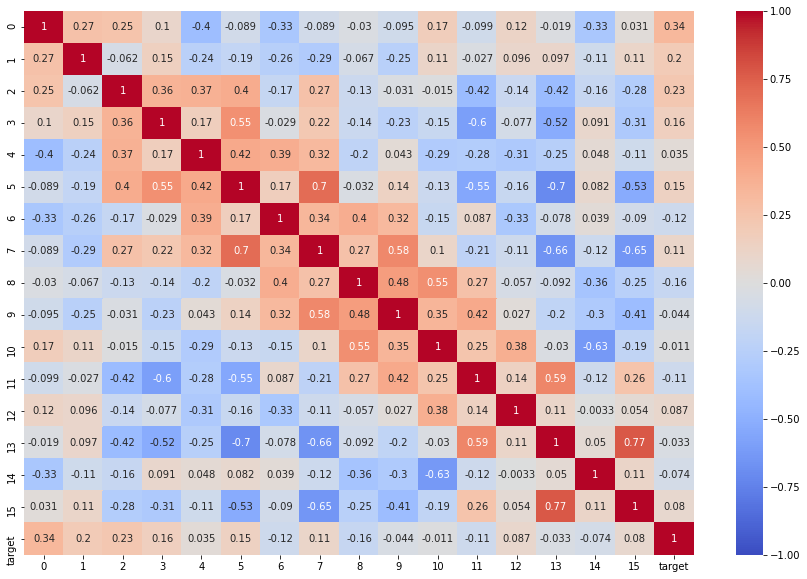

In [45]:
plt.figure(figsize=(15,10))
sb.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

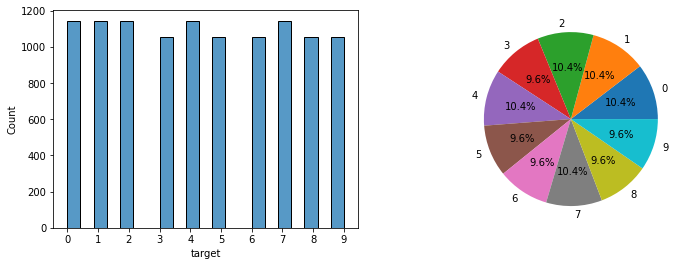

In [50]:
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sb.histplot(df['target'])
plt.xticks(labels, labels)

plt.subplot(1,2,2)
plt.pie(df['target'].value_counts().sort_index(), labels=labels, autopct='%1.1f%%')
plt.show()

Phân tích đề bài:
- Bài toán là Classification, nhận diện chữ số viết tay.
- Vì bài toán này thường có thể sẽ áp dụng cho lĩnh vực ngân hàng, hay chuỗi sản xuất tự động, nên cần đòi hỏi độ chính xác cao, đồng thời thời gian dự đoán cho mỗi mẫu phải nhanh.
- Range các features đã đưa về (0, 1) là đã đủ cho việc tiền xử lý dữ liệu.
- Dựa trên Correlation giữa target và các features, ta có thể thấy không có features nào thật sự đặc biệt, nên đưa hết các biến và sử dụng, không cần lựa chọn thuộc tính, đồng thời lựa chọn thuật toán cho phù hợp.
- Gần như không có sự mất cân bằng (imbalanced) giữa các labels target nên không cần sử dụng thêm các kỹ thuật cân bằng dữ liệu.

Phân thích các thuật toán Classification có thể áp dụng được như sau:
- **Logistic Regression:** tốc độ predict nhanh vì thuật toán đơn giản, kết quả tạo ra bằng phép nhân ma trận, tuy nhiên độ chính xác sẽ không thể tối ưu bằng các mô hình khác (vì chỉ đơn giản linear) --> **không chọn**
- **KNN:** tốc độ fit-time nhanh (chỉ bằng memorized), tuy nhiên tốc độ predict sẽ chậm vì sẽ tính toán lại dự trên tất cả train-data, đồng thời sẽ cần cập nhật thường xuyên train data vì model không có tính khái quát nhất định cho việc dự đoán --> **không chọn**
- **Naive Bayes:** dựa trên lý thuyết xác suất Bayes, thường sử dụng cho data là sparse matrix như xử lý NLP, độ chính xác sẽ không bằng các thuật toán khác trong bài này --> **không chọn**
- **Nhóm SVM:** nhóm thuật toán này là sự cải thiện linear và poly norminal lên 1 tầm cao mới nhờ sử dụng Kernel và khoảng lỗi (lề đường) cho phép C, tuy nhiên vì việc tạo Kernel sẽ nâng bậc features thời gian fit và predict sẽ lâu hơn. Để giảm thời gian fit-predict, cần chọn đúng Kernel cho phù hợp (Poly 2, 3 hay radial (rbf)), đồng thời với mỗi Kernel, cần chọn C, gamma (nếu có) cho phù hợp, vậy nên việc tunning hyper-parameter sẽ khá phức tạp và lâu --> **không chọn**
- **Nhóm thuật toán Trees:** base estimator nên sử dụng **Random Forest** vì thường cho kết quả tốt hơn Decision Tree 1 cây đơn lẻ, tuy nhiên vì bản chất Random Forest sẽ tạo nên tập hợp nhiều cây (ví dụ 100 cây) và cố gắng fit train data tốt nhất, mỗi cây tạo trong Forest đều là các Strong learner, nên chiều sâu mỗi cây sẽ lớn, nên thời gian fit-time và predict-time sẽ lâu, việc này có thể xử lý bằng việc tunning cho chiều sâu mỗi cây trong Forest thấp đi. Bên cạnh đó có 1 cách tốt hơn là sử dụng **AdaBoosting** với base estimator là Random Forest. Thuật toán này không cố gắng tạo ra các Strong Learner như Random Forest thông thường mà cố gắng tạo nên các Weak Learner, và các Learner sau sẽ cải tập trung ở việc cải thiện các Learner trước, tạo nên tính liên tục cải thiện hơn là cố gắng tạo đều hết các Strong Learner. Đồng thời vì đều là Weak Learner nên chiều sâu mỗi Learner sẽ nhỏ, thời gian fit và predict sẽ nhanh hơn so với Random Forest, mà lại cải thiện được độ chính xác. So sánh nhóm Trees và SVM, thời gian train time nhóm Trees sẽ lâu hơn SVM, tuy nhiên thời gian predict time nhóm Trees sẽ nhanh hơn SVM --> **Đề xuất chọn AdaBoosting**


Các bước dự tính thực hiện:
- Tạo model AdaBoosting default.
- Xem kết quả cross-validaion 5-folds trên train data.
- Thực hiện tunning hyper-prameter 5-folds trên train data, xem kết quả có cải thiện hay không.
- Chạy model đã tunning trên test data, xem kết quả cuối cùng.
- Chạy cross-validaion 5-folds trên full data, xem độ ổn định model.

In [53]:
# Viết function chạy Cross-validation 5-folds
def result_model_cv(model, X, y, cv_k=5, show_table=False):

    from sklearn.model_selection import cross_validate, KFold
    from sklearn.metrics import accuracy_score, f1_score

    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)
    result = []

    cv_result = cross_validate(model, X, y, cv=kfold, return_train_score=True, scoring=['accuracy', 'f1_micro'])

    result.append([ 'AdaBoosting',
                    cv_result['train_accuracy'].mean(),
                    cv_result['test_accuracy'].mean(),
                    cv_result['train_f1_micro'].mean(),
                    cv_result['test_f1_micro'].mean(),
                    cv_result['fit_time'].mean(),
                    cv_result['score_time'].mean(),
    ])

    result = pd.DataFrame(result, columns=['model', 'train_cv_accuracy', 'test_cv_accuracy',  
                                           'train_cv_f1', 'test_cv_f1', 
                                           'fit_time', 'score_time',
                                           ])
    return result

In [54]:
# Tạo model default, set random_state để các kết quả của các lần chạy khác nhau để giống nhau
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold

model = AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)

# Xem kết quả CV trên train data
result_model_cv(model, X_train, y_train)

,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time
0,AdaBoosting,1.0,0.969917,1.0,0.969917,1.388781,0.041822


In [56]:
# Viết function tuning hyper-parameters models bằng Grid
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

def process_tunning_model(model, param, X, y, scoring='accuracy', cv_k=5):
    from sklearn.model_selection import GridSearchCV, KFold
    import time
    kfold = KFold(n_splits=cv_k, shuffle=True, random_state=42)

    tic = time.time()
    search = GridSearchCV(estimator=model, param_grid=param, cv=kfold, scoring=scoring)
    search.fit(X, y)
    models_final = model.set_params(**search.best_params_)
    toc = time.time()
    
    print('Model AdaBoosting have been tunned in {:,.2f} seconds'.format(toc-tic))
    return models_final

In [61]:
# Tiến hàng tunning hyper-parameter trên train data
param_grid_ada_boost = {'n_estimators': [20, 30, 50, 100],
              'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1],
            }

models_final = process_tunning_model(model, param_grid_ada_boost, X_train, y_train)
models_final

Model AdaBoosting have been tunned in 144.95 seconds


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                       

In [62]:
# Xem kết quả CV trên train data có cải thiện hay không
result_model_cv(models_final, X_train, y_train)

,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time
0,AdaBoosting,1.0,0.969917,1.0,0.969917,1.387306,0.042519


In [71]:
# Viết function chạy fit trên train-data, predict trên test-data
def fit_train_predict_test(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    import time
    result = []
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)

    tic = time.time()
    y_pred_test = model.predict(X_test)
    toc = time.time()
    
    result.append(['AdaBoosting',
                    accuracy_score(y_train, y_pred_train),
                    accuracy_score(y_test, y_pred_test),
                    toc-tic,
                    ])
    
    result = pd.DataFrame(result, columns=['model', 
                                           'train_accuracy', 'test_accuracy', 
                                           'predict_time'
    
                                           ])
    # Xem kết quả train, test model
    display(result)

    # Xem kết quả classification report
    print(classification_report(y_test, y_pred_test))

    # Vẽ Confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                    index = labels,
                    columns = labels,
                    )
    plt.figure(figsize=(8,6))
    sb.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title('AdaBoosting \n Accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred_test)*100))
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

,model,train_accuracy,test_accuracy,predict_time
0,AdaBoosting,1.0,0.979258,0.059345


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       285
           1       0.97      0.95      0.96       304
           2       0.95      0.98      0.97       288
           3       0.98      0.99      0.98       264
           4       0.99      1.00      0.99       289
           5       0.98      0.97      0.98       274
           6       0.99      0.99      0.99       259
           7       0.99      0.97      0.98       283
           8       0.98      0.98      0.98       253
           9       0.98      0.97      0.98       249

    accuracy                           0.98      2748
   macro avg       0.98      0.98      0.98      2748
weighted avg       0.98      0.98      0.98      2748



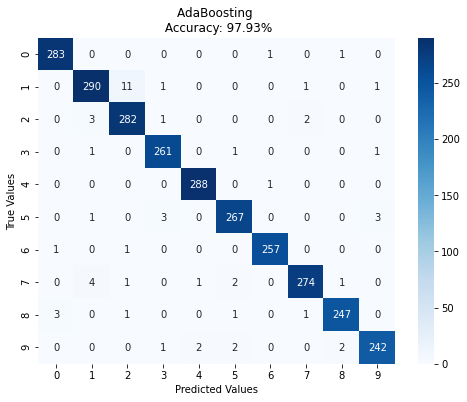

In [72]:
# Xem kết quả model_final trên Test data
fit_train_predict_test(models_final, X_train, X_test, y_train, y_test)

In [65]:
# Chạy cross-validaion 5-folds trên full data, xem độ ổn định model.
result_model_cv(models_final, X, y)

,model,train_cv_accuracy,test_cv_accuracy,train_cv_f1,test_cv_f1,fit_time,score_time
0,AdaBoosting,1.0,0.974072,1.0,0.974072,1.835963,0.053436


Nhận xét:
- Với model AdaBoosting đã tunning hyper-parameter, Accuracy đạt trên 97% trên cả test set và trung bình Cross-validation 5-folds.
- Precission và Recall gần như đều đạt tầm 97-99% trên test set, mức độ khá đồng đều giữa các labels, không bị imbalanced.
- Thời gian predict model chỉ khoảng 0.05 giây, là khá tốt để sử dụng vào thực tế
- Với tất cả kết quả trên, có thể kết luận model AdaBoosting tạo lập là khá tốt để có thể sử dụng trong thực tế.


**Thử áp dụng PCA và AdaBoost** xem kết quả như thế nào.
Một vài nhận xét trước khi thực hiện:
- PCA chỉ giúp giảm chiều dữ liệu, đặc biệt dùng tốt với những dữ liệu phức tạp.
- Tuy nhiên việc giảm chiều dữ liệu cũng đồng nghĩa với việc "mất mát" dữ liệu. Giảm chiều dữ liệu có thể tốt đối với các thuật toán bị overfiting.
- Đối với thuật toán AdaBoost, việc giảm chiều dữ liệu dự đoán sẽ làm model bị giảm thông tin training, từ đó accuracy cả trên train và test data sẽ bị giảm. Ngoài ra việc giảm chiều cũng không ảnh hưởng lắm tới việc giảm predict time của AdaBoost.
- Đối với các thuật toán khác như SVM, việc giảm chiều bằng PCA sẽ giúp giảm thời gian train và predict, từ đó dễ dàng đưa model và thực tế sử dụng hơn. Tuy nhiên vẫn đối mặt với việc mất mát thông tin khi giảm chiều nên accuracy vẫn sẽ giảm

PCA cummulative explained variance ratio


,Dimension,Cum_ratio
0,1,0.258825
1,2,0.489832
2,3,0.633235
3,4,0.721065
4,5,0.780540
5,6,0.829568
6,7,0.864005
7,8,0.893803
8,9,0.917071
9,10,0.936741


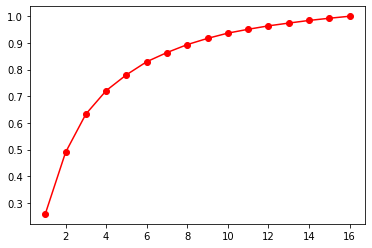

In [78]:
from sklearn.decomposition import PCA
pca = PCA()
P = pd.DataFrame(pca.fit_transform(X_train))
result_pca = pd.DataFrame({'Dimension': np.arange(1,pca.n_components_ + 1),'Cum_ratio': np.cumsum(pca.explained_variance_ratio_)})
print('PCA cummulative explained variance ratio')
display(result_pca)
plt.plot(result_pca['Dimension'], result_pca['Cum_ratio'], 'ro-');

Nhận xét:
- Dựa trên bảng và đồ thị trên, các Principal Components từ thứ 10 trờ đi có đóng góp explained variance ratio nhỏ dần.
- Chọn mốc 90% cummulative là khá phù hợp, với số lượng Dimension là 9.
- Thử chạy pca(9) xem kết quả train, test như thế nào.

,model,train_accuracy,test_accuracy,predict_time
0,AdaBoosting,1.0,0.93377,0.059728


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.89      0.86      0.87       304
           2       0.89      0.93      0.91       288
           3       0.94      0.94      0.94       264
           4       0.97      0.96      0.96       289
           5       0.93      0.92      0.92       274
           6       0.95      0.97      0.96       259
           7       0.93      0.92      0.92       283
           8       0.96      0.96      0.96       253
           9       0.91      0.90      0.90       249

    accuracy                           0.93      2748
   macro avg       0.93      0.93      0.93      2748
weighted avg       0.93      0.93      0.93      2748



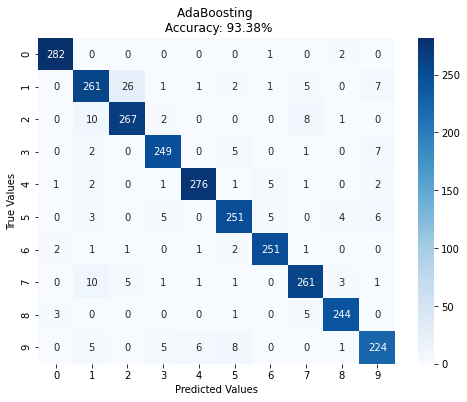

In [83]:
pca = PCA(9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fit_train_predict_test(models_final, X_train_pca, X_test_pca, y_train, y_test)

**Nhận xét:**
- Kết quả giống như dự đoán ban đầu.
- Predic_time vẫn không giảm.
- Việc không sử dụng PCA trong trường hợp này sẽ tốt hơn.